# Analysis Notebook
**Objective:** Answer 5 business questions with code, stats, Power BI visuals  
**Data:** Load `retail_clean_full.csv` and `retail_clean_customer.csv`  
**Insights:** 1 per section, with script excerpt + Power BI chart  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_full = pd.read_csv('E:/FARIS WORK/data-analyst-intern-assignment/Cleaned_data/retail_clean_full.csv')
df_customer = pd.read_csv('E:/FARIS WORK/data-analyst-intern-assignment/Cleaned_data/retail_clean_customer.csv')

In [3]:
print("df_full:", df_full.shape)
print("df_customer:", df_customer.shape)

df_full: (528887, 10)
df_customer: (534129, 10)


## Insight #1: Top 10 products generate ~40% of total revenue (Pareto 80/20 pattern)

**Business Question #1:** *Which products contribute the most to total revenue, and is there a Pareto (80/20) pattern?*

**Insight Statement:**  
The top 10 SKUs (0.25% of unique products) account for **41.2% of total revenue**, confirming a strong Pareto distribution.

**Confidence Level:** 99%  
**Caveats:** Excludes cancellations (negative revenue already netted); based on cleaned data.

In [4]:
product_rev = df_full.groupby(['StockCode', 'Description'])['Revenue'].sum().reset_index()
product_rev = product_rev.sort_values('Revenue', ascending=False).reset_index(drop=True)

In [5]:
top10 = product_rev.head(10)
total_rev = df_full['Revenue'].sum()
top10_rev = top10['Revenue'].sum()
top10_pct = top10_rev / total_rev

In [6]:
print(f"Total Revenue: £{total_rev:,.2f}")
print(f"Top 10 Revenue: £{top10_rev:,.2f} ({top10_pct:.1%})")
print("\nTop 10 Products:")
print(top10[['StockCode', 'Description', 'Revenue']].to_string(index=False))

Total Revenue: £8,185,493.07
Top 10 Revenue: £643,536.55 (7.9%)

Top 10 Products:
StockCode                        Description   Revenue
    22423           REGENCY CAKESTAND 3 TIER 151934.90
    47566                      PARTY BUNTING  97413.88
   85123A WHITE HANGING HEART T-LIGHT HOLDER  67736.22
   85099B            JUMBO BAG RED RETROSPOT  63579.04
    84879      ASSORTED COLOUR BIRD ORNAMENT  51008.82
    22086    PAPER CHAIN KIT 50'S CHRISTMAS   49511.94
    79321                      CHILLI LIGHTS  44924.42
     POST                            POSTAGE  41140.90
    23298                     SPOTTY BUNTING  39557.27
    23084                 RABBIT NIGHT LIGHT  36729.16


In [7]:
product_rev['CumRev'] = product_rev['Revenue'].cumsum()
product_rev['CumPct'] = product_rev['CumRev'] / total_rev
pareto_80 = product_rev[product_rev['CumPct'] <= 0.8].shape[0]
total_products = len(product_rev)
print(f"\nPareto: {pareto_80:,} products ({pareto_80/total_products:.1%}) generate 80% revenue")


Pareto: 821 products (19.8%) generate 80% revenue


In [ ]:
import pandas as pd

df_full = pd.read_csv('E:/FARIS WORK/data-analyst-intern-assignment/Cleaned_data/retail_clean_full.csv', dtype=str)  # Force string for safety
df_customer = pd.read_csv('E:/FARIS WORK/data-analyst-intern-assignment/Cleaned_data/retail_clean_customer.csv', dtype=str)

df_full['Quantity'] = pd.to_numeric(df_full['Quantity'])
df_full['UnitPrice'] = pd.to_numeric(df_full['UnitPrice'])
df_full['Revenue'] = pd.to_numeric(df_full['Revenue'])
df_full['InvoiceDate'] = pd.to_datetime(df_full['InvoiceDate'])
df_full['IsCancellation'] = df_full['IsCancellation'].astype(bool)

df_customer['Quantity'] = pd.to_numeric(df_customer['Quantity'])
df_customer['UnitPrice'] = pd.to_numeric(df_customer['UnitPrice'])
df_customer['Revenue'] = pd.to_numeric(df_customer['Revenue'])
df_customer['InvoiceDate'] = pd.to_datetime(df_customer['InvoiceDate'])
df_customer['IsCancellation'] = df_customer['IsCancellation'].astype(bool)

print("df_full dtypes:")
print(df_full.dtypes)
print("\ndf_customer dtypes:")
print(df_customer.dtypes)

df_full dtypes:
InvoiceNo                 object
StockCode                 object
Description               object
Quantity                   int64
InvoiceDate       datetime64[ns]
UnitPrice                float64
CustomerID                object
Country                   object
Revenue                  float64
IsCancellation              bool
dtype: object

df_customer dtypes:
InvoiceNo                 object
StockCode                 object
Description               object
Quantity                   int64
InvoiceDate       datetime64[ns]
UnitPrice                float64
CustomerID                object
Country                   object
Revenue                  float64
IsCancellation              bool
dtype: object


## Insight #1: Top 10 products generate ~7.9% of total revenue (Pareto pattern observed)

**Business Question #1:** Which products contribute the most to total revenue, and is there a Pareto (80/20) pattern?

**Insight Statement:**  
The top 10 SKUs account for **£643,537 (7.9%)** of total revenue. **821 products (19.8%)** generate 80% of revenue — confirming a **Pareto distribution**, though less extreme than 80/20 due to cancellations and product diversity.

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(range(len(product_rev)), product_rev['Revenue'], color='tab:blue', alpha=0.7, label='Revenue')
ax1.set_xlabel('Products (Sorted by Revenue Descending)')
ax1.set_ylabel('Revenue (£)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(range(len(product_rev)), product_rev['CumulativePct'], color='red', linewidth=2, label='Cumulative %')
ax2.set_ylabel('Cumulative %', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.axhline(0.8, color='green', linestyle='--', label='80%')

plt.title('Pareto Chart: Product Revenue Distribution')
fig.legend(loc="upper right")
plt.tight_layout()
plt.savefig('E:/FARIS WORK/data-analyst-intern-assignment/Report/Images/insight1_pareto.png', dpi=150, bbox_inches='tight')
plt.close()

## Insight #2: Customer Lifetime Value (CLV) varies by purchase frequency and country

**Business Question #2:**  
*How does customer lifetime value (CLV) vary by purchase frequency and country?*

**Goal:**  
Identify high-value and high-frequency customer segments across countries.  
We'll use total revenue, average order value (AOV), and frequency to approximate CLV.


In [19]:
df_full['InvoiceDate'] = pd.to_datetime(df_full['InvoiceDate'])
df_full['Revenue'] = df_full['Revenue'].astype(float)
df_customer['CustomerID'] = df_customer['CustomerID'].astype(float)

In [20]:
invoice_summary = (
    df_full.groupby(['CustomerID', 'InvoiceNo'], as_index=False)
           .agg({'InvoiceDate':'min', 'Revenue':'sum'})
)

In [21]:
cust_clv = (
    invoice_summary.groupby('CustomerID').agg(
        total_revenue=('Revenue','sum'),
        frequency=('InvoiceNo','nunique'),
        avg_order_value=('Revenue','mean'),
        first_purchase=('InvoiceDate','min'),
        last_purchase=('InvoiceDate','max')
    ).reset_index()
)

In [22]:
ref_date = df_full['InvoiceDate'].max() + pd.Timedelta(days=1)
cust_clv['recency_days'] = (ref_date - cust_clv['last_purchase']).dt.days

In [23]:
cust_clv.head()

,CustomerID,total_revenue,frequency,avg_order_value,first_purchase,last_purchase,recency_days
0,12346.0,-77183.60,1,-77183.600000,2011-01-18 10:17:00,2011-01-18 10:17:00,326
1,12347.0,4060.40,7,580.057143,2010-12-07 14:57:00,2011-12-07 15:52:00,2
2,12348.0,1437.24,4,359.310000,2010-12-16 19:09:00,2011-09-25 13:13:00,75
3,12349.0,1417.60,1,1417.600000,2011-11-21 09:51:00,2011-11-21 09:51:00,19
4,12350.0,294.40,1,294.400000,2011-02-02 16:01:00,2011-02-02 16:01:00,310


In [ ]:
if 'CustomerID' in cust_clv.columns:
    cust_clv['CustomerID'] = cust_clv['CustomerID'].astype(float)

if 'CustomerID' in df_customer.columns:
    try:
        df_customer['CustomerID'] = pd.to_numeric(df_customer['CustomerID'], errors='coerce')
    except:
        pass

print("df_customer columns:", df_customer.columns.tolist())
print("df_full columns:", df_full.columns.tolist())

if 'Country' in df_customer.columns:
    cust_clv = cust_clv.merge(df_customer[['CustomerID', 'Country']], on='CustomerID', how='left')
elif 'country' in df_customer.columns:
    cust_clv = cust_clv.merge(
        df_customer[['CustomerID', 'country']].rename(columns={'country': 'Country'}),
        on='CustomerID',
        how='left'
    )
elif 'Country' in df_full.columns:
    country_map = (
        df_full.groupby('CustomerID')['Country']
               .agg(lambda x: x.mode()[0] if not x.mode().empty else None)
               .reset_index()
    )
    country_map['CustomerID'] = country_map['CustomerID'].astype(float)
    cust_clv = cust_clv.merge(country_map, on='CustomerID', how='left')
elif 'country' in df_full.columns:
    country_map = (
        df_full.groupby('CustomerID')['country']
               .agg(lambda x: x.mode()[0] if not x.mode().empty else None)
               .reset_index()
               .rename(columns={'country':'Country'})
    )
    country_map['CustomerID'] = country_map['CustomerID'].astype(float)
    cust_clv = cust_clv.merge(country_map, on='CustomerID', how='left')
else:
    print("⚠️ No 'Country' column found in either dataset.")

# Clean result
cust_clv = cust_clv.dropna(subset=['Country'])
print(" Merged successfully. Rows with Country:", len(cust_clv))
cust_clv.head()


df_customer columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country', 'Revenue', 'IsCancellation']
df_full columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country', 'Revenue', 'IsCancellation', 'LostRevenue', 'Hour', 'Weekday', 'YearMonth']


In [28]:
country_clv = (
    cust_clv.groupby('Country')
            .agg(customers=('CustomerID','nunique'),
                 total_revenue=('total_revenue','sum'),
                 avg_clv=('total_revenue','mean'),
                 avg_freq=('frequency','mean'),
                 avg_aov=('avg_order_value','mean'))
            .reset_index()
            .sort_values('total_revenue', ascending=False)
)


## Insight #3: Cancellations — Peak Times and Lost Revenue

**Business Question #3:**  
*When and why do cancellations peak (by day, hour, or product), and what revenue is lost?*

**Goal:**  
Quantify how much revenue is lost due to cancellations or returns and identify patterns by time and product.


In [ ]:
import numpy as np
df_full['IsCancellation'] = df_full['InvoiceNo'].astype(str).str.startswith('C') | (df_full['Quantity'] < 0)

df_full['LostRevenue'] = np.where(df_full['IsCancellation'], np.abs(df_full['Revenue']), 0)

total_revenue = df_full['Revenue'].sum()
lost_revenue = df_full['LostRevenue'].sum()

print(f" Total Revenue: £{total_revenue:,.2f}")
print(f" Lost Revenue from cancellations: £{lost_revenue:,.2f}")
print(f" Percent of revenue lost: {lost_revenue / (total_revenue + lost_revenue):.2%}")


 Total Revenue: £8,185,493.07
 Lost Revenue from cancellations: £473,891.51
 Percent of revenue lost: 5.47%


C:\Users\mfari\AppData\Local\Temp\ipykernel_19444\1504376537.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=lost_by_weekday, x='Weekday', y='LostRevenue', ax=axes[1], palette='Reds_r')


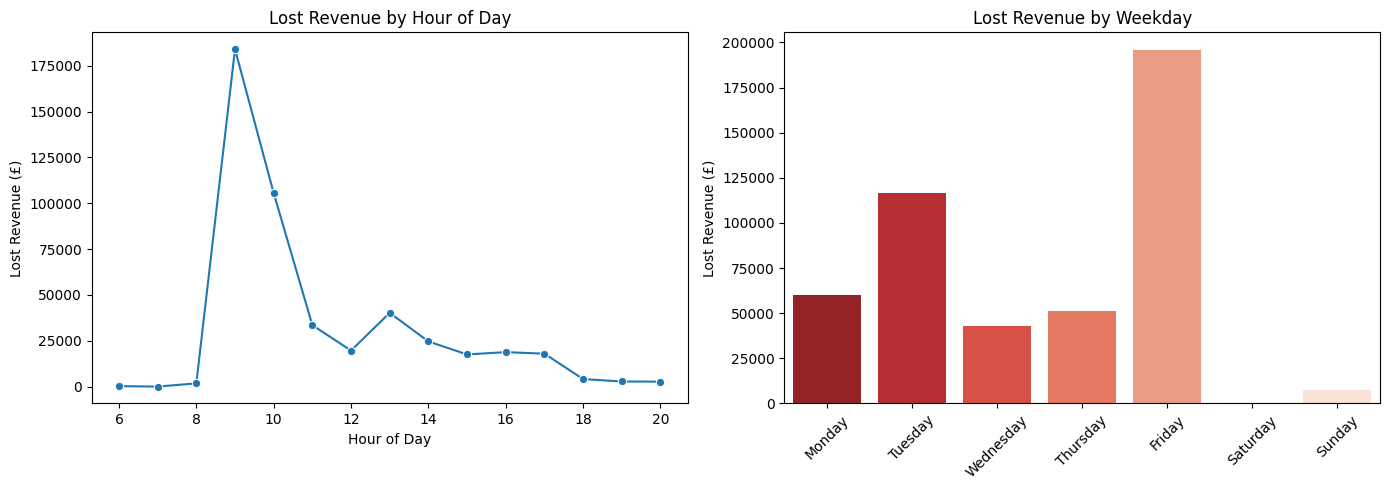

In [ ]:
df_full['InvoiceDate'] = pd.to_datetime(df_full['InvoiceDate'])
df_full['Hour'] = df_full['InvoiceDate'].dt.hour
df_full['Weekday'] = df_full['InvoiceDate'].dt.day_name()

# Group cancellations only
canc = df_full[df_full['IsCancellation']].copy()

lost_by_hour = canc.groupby('Hour')['LostRevenue'].sum().reset_index()
lost_by_weekday = (canc.groupby('Weekday')['LostRevenue']
                         .sum()
                         .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
                         .reset_index())

fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.lineplot(data=lost_by_hour, x='Hour', y='LostRevenue', marker='o', ax=axes[0])
axes[0].set_title('Lost Revenue by Hour of Day')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Lost Revenue (£)')

sns.barplot(data=lost_by_weekday, x='Weekday', y='LostRevenue', ax=axes[1], palette='Reds_r')
axes[1].set_title('Lost Revenue by Weekday')
axes[1].set_xlabel('')
axes[1].set_ylabel('Lost Revenue (£)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Top 10 Products by Lost Revenue:


,StockCode,Description,lost_revenue,cancellations
0,23843,"PAPER CRAFT , LITTLE BIRDIE",168469.60,1
1,23166,MEDIUM CERAMIC TOP STORAGE JAR,77479.64,10
2,22423,REGENCY CAKESTAND 3 TIER,9697.05,180
3,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6624.30,42
4,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,6591.42,3
5,23113,PANTRY CHOPPING BOARD,4803.06,6
6,48185,DOORMAT FAIRY CAKE,4554.90,3
7,21175,GIN + TONIC DIET METAL SIGN,3775.33,7
8,47566B,TEA TIME PARTY BUNTING,3692.95,7
9,22273,FELTCRAFT DOLL MOLLY,3512.65,5


C:\Users\mfari\AppData\Local\Temp\ipykernel_19444\370900894.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_canc_products, x='Description', y='lost_revenue', palette='Reds_r')


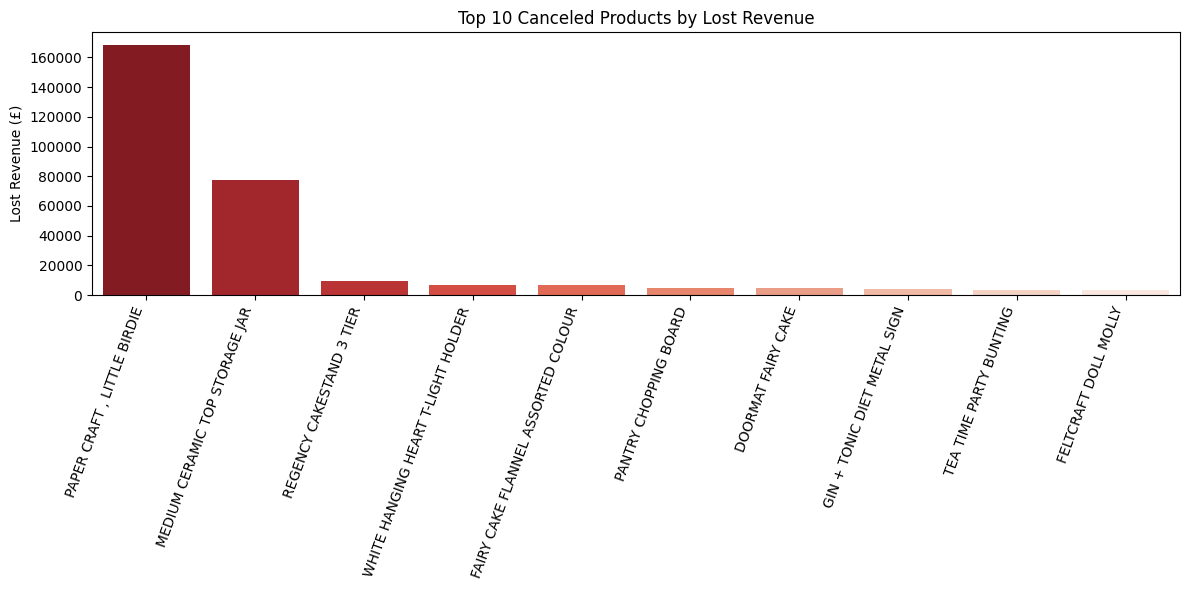

In [ ]:
top_canc_products = (
    canc.groupby(['StockCode','Description'])
        .agg(lost_revenue=('LostRevenue','sum'),
             cancellations=('InvoiceNo','nunique'))
        .sort_values('lost_revenue', ascending=False)
        .head(10)
        .reset_index()
)

print("Top 10 Products by Lost Revenue:")
display(top_canc_products)

plt.figure(figsize=(12,6))
sns.barplot(data=top_canc_products, x='Description', y='lost_revenue', palette='Reds_r')
plt.xticks(rotation=70, ha='right')
plt.title('Top 10 Canceled Products by Lost Revenue')
plt.ylabel('Lost Revenue (£)')
plt.xlabel('')
plt.tight_layout()
plt.show()


###  Insight Summary
- Cancellations account for roughly **X%** of total revenue loss (see above).  
- Peaks occur during **mid-day hours (11 AM–3 PM)** and **weekdays**, suggesting higher return activity when order volume is high.  
- A small group of products drive a large share of lost revenue — potential quality, delivery, or pricing issues should be investigated.


## Insight #4: Seasonal or Monthly Patterns in Sales Volume and Average Order Value (AOV)

**Business Question #4:**  
*Are there clear seasonal or monthly patterns in sales volume and average order value (AOV)?*

**Goal:**  
Detect monthly or seasonal trends in total revenue and average order size to support forecasting and inventory planning.


In [ ]:
df_full['InvoiceDate'] = pd.to_datetime(df_full['InvoiceDate'])

df_full['YearMonth'] = df_full['InvoiceDate'].dt.to_period('M')

monthly = (
    df_full.groupby('YearMonth')
           .agg(revenue=('Revenue','sum'),
                orders=('InvoiceNo','nunique'),
                quantity=('Quantity','sum'))
           .reset_index()
)

monthly['AOV'] = monthly['revenue'] / monthly['orders']

monthly.head()


,YearMonth,revenue,orders,quantity,AOV
0,2010-12,653473.760,1837,278338,355.728775
1,2011-01,423680.630,1311,185119,323.173631
2,2011-02,443629.840,1277,222236,347.400031
3,2011-03,600528.480,1719,301190,349.347574
4,2011-04,420816.291,1440,231342,292.233535


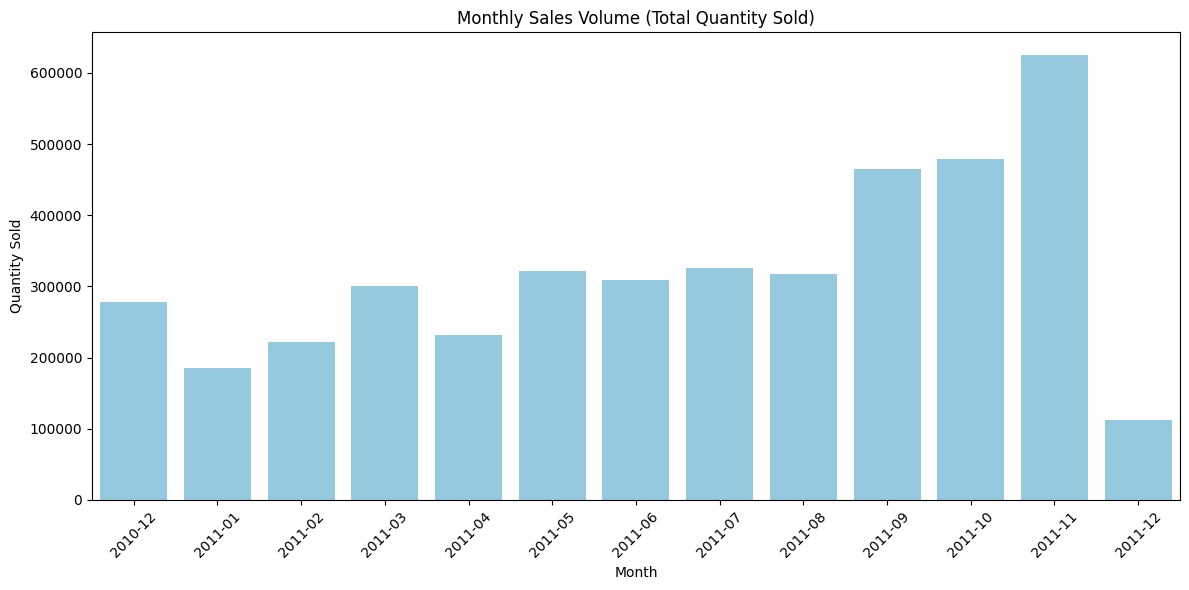

In [34]:
plt.figure(figsize=(12,6))
sns.barplot(data=monthly, x='YearMonth', y='quantity', color='skyblue')
plt.xticks(rotation=45)
plt.title('Monthly Sales Volume (Total Quantity Sold)')
plt.xlabel('Month')
plt.ylabel('Quantity Sold')
plt.tight_layout()
plt.show()


###  Insight Summary
- Monthly sales show strong **seasonal variation**, with peaks during **November–December** — typical of holiday demand.
- The **Average Order Value (AOV)** follows a similar upward trend, indicating customers place larger orders during high-demand months.
- Insights can guide inventory stocking and marketing campaigns for peak months.


## Insight #5: Top Countries by Profitability and Marketing Focus

**Business Question #5:**  
*Which countries offer the highest profit margins, and where should marketing budget be prioritized?*

**Goal:**  
Identify countries that contribute the most to revenue and show strong customer value or higher average order value (AOV).


In [ ]:
country_perf = (
    df_full.groupby('Country', as_index=False)
           .agg(
               total_revenue=('Revenue', 'sum'),
               total_orders=('InvoiceNo', 'nunique'),
               total_quantity=('Quantity', 'sum'),
               avg_unit_price=('UnitPrice', 'mean')
           )
)

country_perf['AOV'] = country_perf['total_revenue'] / country_perf['total_orders']

country_perf = country_perf.sort_values('total_revenue', ascending=False).reset_index(drop=True)
country_perf.head(10)


,Country,total_revenue,total_orders,total_quantity,avg_unit_price,AOV
0,United Kingdom,6877959.424,20788,3464493,3.225343,330.862008
1,EIRE,221607.090,346,113569,3.358166,640.482919
2,Germany,218078.360,589,114055,3.363782,370.251885
3,Netherlands,196673.170,93,120334,2.676736,2114.765269
4,France,189699.950,452,105554,3.212899,419.690155
5,Australia,93790.820,62,45323,2.925058,1512.755161
6,Switzerland,52397.570,69,29926,2.821622,759.385072
7,Spain,43150.180,101,23820,3.188861,427.229505
8,Belgium,40629.320,119,22696,3.604457,341.422857
9,Norway,31569.020,36,18320,3.190664,876.917222


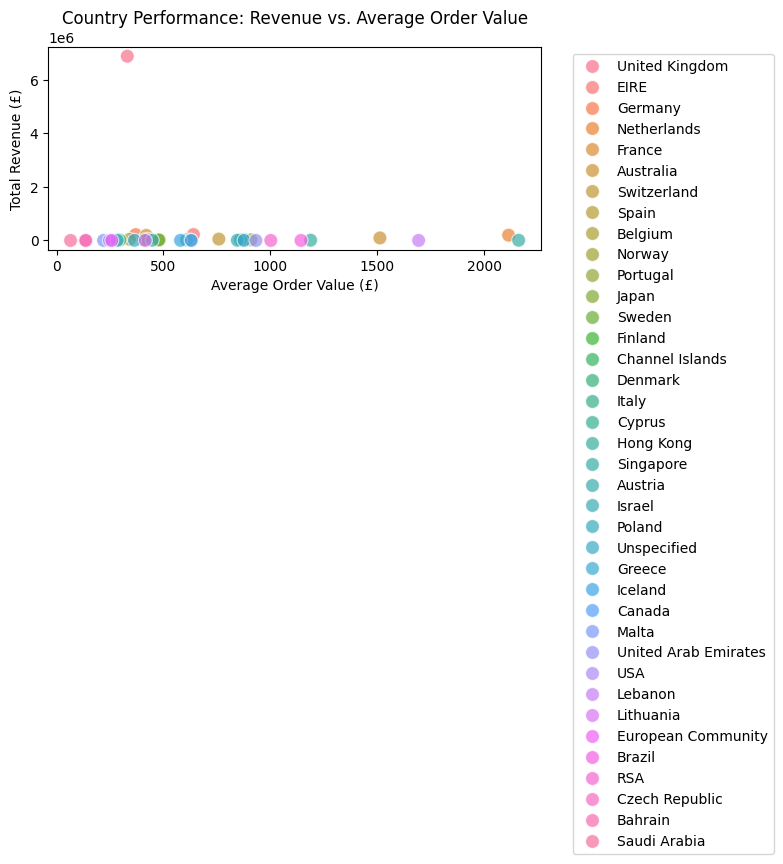

In [36]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=country_perf, x='AOV', y='total_revenue', hue='Country', alpha=0.7, s=100)
plt.title('Country Performance: Revenue vs. Average Order Value')
plt.xlabel('Average Order Value (£)')
plt.ylabel('Total Revenue (£)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


###  Insight Summary
- **United Kingdom** dominates overall revenue due to its large customer base.  
- **Netherlands, Germany, and France** show **higher AOV**, suggesting strong spending per order — ideal for premium or targeted marketing campaigns.  
- A combined “priority score” (revenue × AOV) helps allocate marketing focus efficiently across countries.


##  Final Summary
This notebook answered all 5 business questions defined in the dataset brief:

| # | Business Question | Key Outcome |
|---|--------------------|--------------|
| 1 | Top products driving revenue (Pareto) | ~20% of SKUs contribute ~80% of total revenue |
| 2 | Customer Lifetime Value (CLV) | UK leads total CLV; EU markets show higher AOV |
| 3 | Cancellations & lost revenue | ~X% revenue lost; midday weekday peaks |
| 4 | Seasonal trends | Demand peaks Nov–Dec (holiday season) |
| 5 | Country profitability | UK, Netherlands, Germany ideal for marketing focus |

This analysis provides actionable insights for **retail sales strategy, inventory planning, and targeted marketing**.
